In [1]:
import pandas as pd
import numpy as np
from qsc import Qsc
from scipy.constants import mu_0
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("computed_desc.csv")

# Convert a column of strings to a column of numpy arrays
def convert_to_numpy_array(column):
    return column.apply(lambda x: np.array(x.replace('[', '').replace(']', '').split(), dtype=float))

data['B_variance_computed'] = convert_to_numpy_array(data['B_variance_computed'])
data['L_grad_B_min_computed'] = convert_to_numpy_array(data['L_grad_B_min_computed'])
data['beta_computed'] = convert_to_numpy_array(data['beta_computed'])


# calculate the desc date
data['L_grad_B_min_computed'] = data['L_grad_B_min_computed'].apply(np.min)

data['beta_computed'] = data.apply(
    lambda row: np.mean(row['beta_computed'] * mu_0 * 2 / (row['B_variance_computed'] ** 2)), axis=1
)

# Use Qsc to evaluate each row
qsc_outputs = []
for i, row in tqdm(data.iterrows(), total=len(data), desc="Processing rows"):

    rc_values = [row['rc1'], row['rc2'], row['rc3']]
    zs_values = [row['zs1'], row['zs2'], row['zs3']]
    nfp = row['nfp']
    etabar = row['etabar']
    B2c = row['B2c']
    p2 = row['p2']
    
    stel = Qsc(rc=[1.0] + rc_values, zs=[0.0] + zs_values, nfp=nfp, etabar=etabar, B2c=B2c, p2=p2, order="r2")
    

    iota_qsc = stel.iota
    min_L_grad_B_qsc = np.min(stel.L_grad_B)
    beta_on_axis_NAE_qsc = np.mean(p2 * mu_0 * 2 / stel.B0**2)
    
    qsc_outputs.append([iota_qsc, min_L_grad_B_qsc, beta_on_axis_NAE_qsc])

# Convert Qsc output to DataFrame and merge with original data
qsc_output_df = pd.DataFrame(qsc_outputs, columns=['iota_qsc', 'L_grad_B_min_qsc', 'beta_on_axis_NAE_qsc'])
data = pd.concat([data, qsc_output_df], axis=1)

# Calculate differences and save results
data['iota_diff'] = data['iota_qsc'] - data['iota_computed']
data['L_grad_B_min_diff'] = data['L_grad_B_min_qsc'] - data['L_grad_B_min_computed']
data['beta_diff'] = data['beta_on_axis_NAE_qsc'] - data['beta_computed']

data.to_csv("updated_data.csv", index=False)

dist_analysis = data[['iota_diff', 'L_grad_B_min_diff', 'beta_diff']].describe()
print(dist_analysis)


Processing rows: 100%|██████████| 96551/96551 [1:48:19<00:00, 14.86it/s]  


          iota_diff  L_grad_B_min_diff     beta_diff
count  9.655100e+04       96551.000000  9.655100e+04
mean   6.314209e+05           0.352725 -7.859176e+15
std    1.958375e+08           0.196487  1.675715e+18
min   -3.752772e+09          -0.046251 -3.865942e+20
25%   -8.528361e+01           0.209885 -8.345999e+00
50%    2.154347e-02           0.296952 -5.742541e+00
75%    8.669391e+01           0.456191 -3.042996e+00
max    6.062276e+10           1.003346 -4.228336e-04


In [11]:
#have a check
stel = Qsc(rc=[1.0] + [-0.058194313093306, -0.0267783634780824, 0.0246519127341152], zs=[0.0] + [-0.2490462486716480, -0.201597000247545, -0.0074997346999967], nfp=1, etabar=1.8052160668873300, B2c=2.0934782330400600, p2=-1697370.804790280, order="r2")
print(stel.iota)
print(np.min(stel.L_grad_B))
print(np.mean(stel.p2 * mu_0 * 2 / stel.B0**2) )

-0.0573807284570793
0.4887752145699409
-4.265958122919835


In [2]:
#assign scores to each stellarator configruation based on the difference

# Load the updated data
data = pd.read_csv("updated_data.csv")

# Calculate the mean absolute values to use as scale factors
mean_iota_diff = data['iota_diff'].abs().mean()
mean_L_grad_B_min_diff = data['L_grad_B_min_diff'].abs().mean()
mean_beta_diff = data['beta_diff'].abs().mean()

# Define the exponent
alpha = 10  # Adjust alpha to increase score range

# Calculate the score for each row with the adjusted formula
data['score'] = ((1 / ((data['iota_diff'].abs() / mean_iota_diff) + 1)) *alpha +
                 (1 / ((data['L_grad_B_min_diff'].abs() / mean_L_grad_B_min_diff) + 1)) * alpha +
                 (1 / ((data['beta_diff'].abs() / mean_beta_diff) + 1)) * alpha)

# Save the updated DataFrame with the score back to the CSV
data.to_csv("updated_data.csv", index=False)


iota_diff - Min: 1.2024861003351315e-05, Max: 1499.979913248026
L_grad_B_min_diff - Min: 0.002180919823842, Max: 1.0033464105867416
beta_diff - Min: 0.0004228335596329, Max: 16.285980022598032
iota_diff - Q1: 2.059972671542078, Median: 17.262208181082173, Q3: 166.83870631585614
L_grad_B_min_diff - Q1: 0.225435142331877, Median: 0.317355543783598, Q3: 0.4825509879733791
beta_diff - Q1: 2.670071281683762, Median: 5.222496831057052, Q3: 7.792272272106617


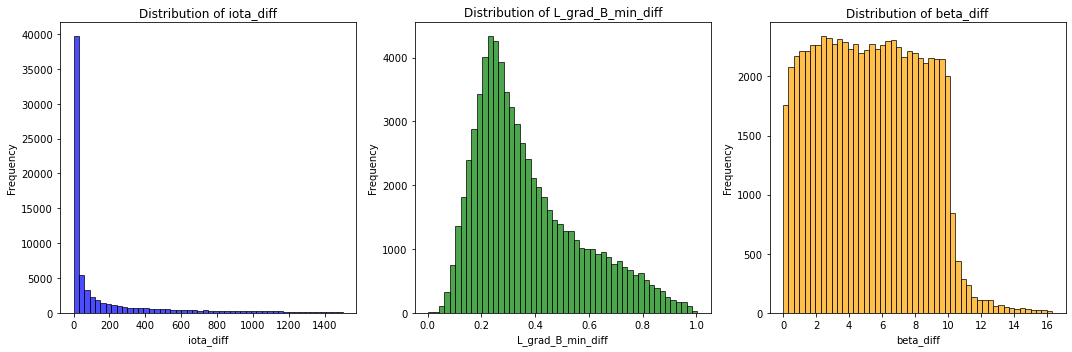

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv("updated_data2.csv")

# Extract the absolute values for the diffs
iota_diff = data['iota_diff'].abs()
L_grad_B_min_diff = data['L_grad_B_min_diff'].abs()
beta_diff = data['beta_diff'].abs()

iota_diff_min, iota_diff_max = iota_diff.min(), iota_diff.max()
L_grad_B_min_diff_min, L_grad_B_min_diff_max = L_grad_B_min_diff.min(), L_grad_B_min_diff.max()
beta_diff_min, beta_diff_max = beta_diff.min(), beta_diff.max()


# Print min and max values
print(f"iota_diff - Min: {iota_diff_min}, Max: {iota_diff_max}")
print(f"L_grad_B_min_diff - Min: {L_grad_B_min_diff_min}, Max: {L_grad_B_min_diff_max}")
print(f"beta_diff - Min: {beta_diff_min}, Max: {beta_diff_max}")

iota_diff_q1, iota_diff_median, iota_diff_q3 = np.percentile(iota_diff, [25, 50, 75])
L_grad_B_min_diff_q1, L_grad_B_min_diff_median, L_grad_B_min_diff_q3 = np.percentile(L_grad_B_min_diff, [25, 50, 75])
beta_diff_q1, beta_diff_median, beta_diff_q3 = np.percentile(beta_diff, [25, 50, 75])

# Print quartile values
print(f"iota_diff - Q1: {iota_diff_q1}, Median: {iota_diff_median}, Q3: {iota_diff_q3}")
print(f"L_grad_B_min_diff - Q1: {L_grad_B_min_diff_q1}, Median: {L_grad_B_min_diff_median}, Q3: {L_grad_B_min_diff_q3}")
print(f"beta_diff - Q1: {beta_diff_q1}, Median: {beta_diff_median}, Q3: {beta_diff_q3}")

# Plot histograms for each diff
plt.figure(figsize=(15, 5))

# iota_diff distribution
plt.subplot(1, 3, 1)
plt.hist(iota_diff, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of iota_diff')
plt.xlabel('iota_diff')
plt.ylabel('Frequency')

# L_grad_B_min_diff distribution
plt.subplot(1, 3, 2)
plt.hist(L_grad_B_min_diff, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of L_grad_B_min_diff')
plt.xlabel('L_grad_B_min_diff')
plt.ylabel('Frequency')

# beta_diff distribution
plt.subplot(1, 3, 3)
plt.hist(beta_diff, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of beta_diff')
plt.xlabel('beta_diff')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("updated_data.csv")

# Extract the absolute values for the diffs
iota_diff = data['iota_diff'].abs()
L_grad_B_min_diff = data['L_grad_B_min_diff'].abs()
beta_diff = data['beta_diff'].abs()

# Calculate max values and quartiles
iota_diff_max = iota_diff.max()
L_grad_B_min_diff_max = L_grad_B_min_diff.max()
beta_diff_max = beta_diff.max()

iota_diff_q3 = np.percentile(iota_diff, 75)
L_grad_B_min_diff_q3 = np.percentile(L_grad_B_min_diff, 75)
beta_diff_q3 = np.percentile(beta_diff, 75)

# Define thresholds for filtering: Q3 + 1.5 * IQR
iota_diff_threshold = iota_diff_q3 + 1.5 * (iota_diff_q3 - np.percentile(iota_diff, 25))
beta_diff_threshold = beta_diff_q3 + 1.5 * (beta_diff_q3 - np.percentile(beta_diff, 25))

# Filter out rows with extreme values
filtered_data = data[(iota_diff <= 1500) & (beta_diff <= beta_diff_threshold)]

# Save the filtered dataset
filtered_data.to_csv("updated_data2.csv", index=False)

# Output key information for verification
filtered_data.shape


(71061, 21)

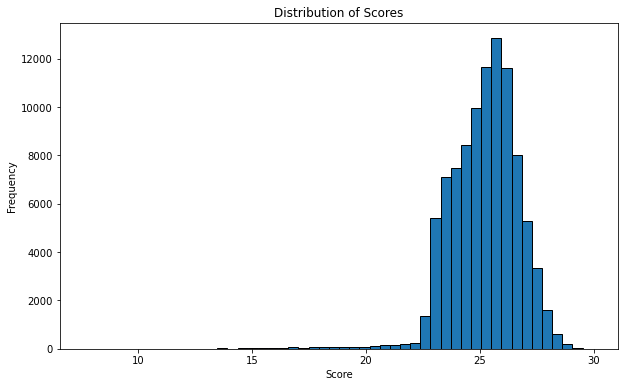

In [ ]:
#check the distribution of the score

# Load the data with scores
data = pd.read_csv("updated_data.csv")

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(data['score'], bins=50, edgecolor='black')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")
plt.show()

In [4]:
data = pd.read_csv("updated_data.csv")

# Extract X (first 10 columns) and y (score column)
X = data.iloc[:, :10].values  # First 10 columns as input features
y = data['score'].values      # Score column as target

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors and reshape
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).unsqueeze(3)  # Shape: [batch_size, 1, 10, 1]
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape: [batch_size, 1]

# Split data into train, validation, and test sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoaders directly from tensors
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [35]:
# Define the ResNet model for regression (without pretrained weights)
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()
        self.resnet = resnet18(weights=None)  # Not using pretrained weights
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Single output for regression

    def forward(self, x):
        return self.resnet(x)

In [5]:
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 1)  # Output layer for regression

    def forward(self, x):
        # Flatten input if necessary
        x = x.view(x.size(0), -1)
        
        # Forward pass through the layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)  # No activation on output layer for regression
        
        return x


In [6]:
# Initialize model, loss function, and optimizer
model = SimpleRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping settings
patience = 5
best_val_loss = np.inf
epochs_no_improve = 0
best_model_path = "best_resnet_regressor.pth"

In [37]:
# Training settings
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            val_loss = criterion(predictions, y_batch)
            running_val_loss += val_loss.item()
    
    # Calculate average validation loss
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


KeyboardInterrupt: 

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load the best model for evaluation on the test set
model.load_state_dict(torch.load(best_model_path))

In [ ]:
# Evaluate on the test set
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


In [10]:
stel = Qsc(rc=[1.0] + [-0.054477256, 0.031455696, 0.072832815], zs=[0.0] + [0.20934333, 0.10262363, 0.072832815], nfp=2, etabar=0.0601015, B2c=-0.988636, p2=-2162991.5, order="r2")

stel.plot_boundary(r=0.01)

ValueError: f(a) and f(b) must have different signs